In [ ]:
# We make an 'arima' folder/environment to work with:

import os

# Specify the folder name
folder_name = 'arima'

# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'arima' created.


In [ ]:
# Navigate to the repository directory
%cd arima

/content/arima


In [ ]:
import numpy as np
import pandas as pd

# upload the df.csv to the arima folder/environment

df= pd.read_csv("df.csv")
df['Datetime (Local)']=pd.to_datetime(df['Datetime (Local)'])
df=df.set_index('Datetime (Local)')
df=df[['Price (EUR/MWhe)']]
df=df.tail(10000)
df

,Price (EUR/MWhe)
Datetime (Local),
2021-04-10 08:00:00,66.20
2021-04-10 09:00:00,69.19
2021-04-10 10:00:00,64.51
2021-04-10 11:00:00,61.21
2021-04-10 12:00:00,59.37
...,...
2022-05-31 19:00:00,249.80
2022-05-31 20:00:00,254.67
2022-05-31 21:00:00,247.51


We normalize the data:

In [ ]:
from sklearn.preprocessing import StandardScaler

# "Price (EUR/MWhe)" is the column to scale
column_to_scale = "Price (EUR/MWhe)"

# Extract the column and reshape it to a 2D array
column_data = df[column_to_scale].values.reshape(-1, 1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the column data
scaler.fit(column_data)

# Transform the column data using the fitted scaler
scaled_column_data = scaler.transform(column_data)

# Replace the original column with the scaled values
df[column_to_scale] = scaled_column_data

df

,Price (EUR/MWhe)
Datetime (Local),
2021-04-10 08:00:00,-0.956049
2021-04-10 09:00:00,-0.927007
2021-04-10 10:00:00,-0.972464
2021-04-10 11:00:00,-1.004517
2021-04-10 12:00:00,-1.022388
...,...
2022-05-31 19:00:00,0.827245
2022-05-31 20:00:00,0.874547
2022-05-31 21:00:00,0.805003


Stationarity test:

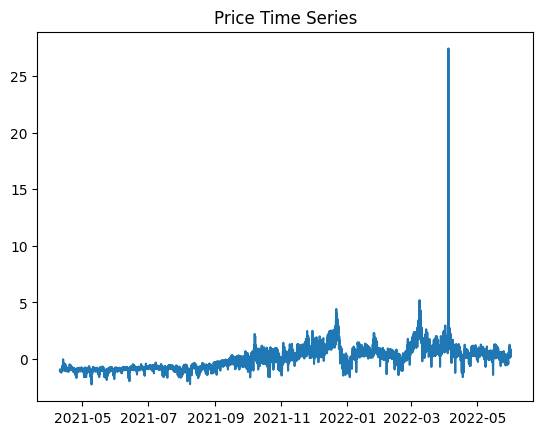

ADF Statistic: -4.275310869520625
p-value: 0.0004900348047430845
Critical Values:
   1%: -3.4310063959152686
   5%: -2.86183008783646
   10%: -2.566924408618826


In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with a 'Price' column
# Make sure your 'Price' column is in datetime format
#df['Date'] = pd.to_datetime(df['Date'])  # Replace 'Date' with your actual date column name

# Set the 'Date' column as the index
#df.set_index('Date', inplace=True)

# Extract the 'Price' column
price_series = df['Price (EUR/MWhe)']

# Function to perform the ADF test and print the results
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Plot the time series
plt.plot(price_series)
plt.title('Price Time Series')
plt.show()

# Perform the ADF test
adf_test(price_series)


ADF Statistic: This is the test statistic from the ADF test. In order to reject the null hypothesis (which assumes non-stationarity), the ADF Statistic should be more negative than the critical values.

p-value: If the p-value is less than a chosen significance level (commonly 0.05), you can reject the null hypothesis.

Critical Values: These are threshold values at different significance levels (1%, 5%, and 10%). If the ADF Statistic is more negative than these critical values, you can reject the null hypothesis.

In summary, with a small p-value and an ADF Statistic more negative than the critical values, you may conclude that your time series is stationary.

In [ ]:
# Extract the first 8000 rows for training and the last 2000 rows for testing
train_data = df.iloc[:8000]['Price (EUR/MWhe)']
test_data = df.iloc[8000:]['Price (EUR/MWhe)']

Choosing (p,d,q) order:

Integrated Order (d):

Since your series is already stationary, d would be 0. You've achieved stationarity without differencing, so d=0.
Autoregressive Order (p):

The autoregressive order (p) is the number of lag observations included in the model. You can determine the value of p by examining the partial autocorrelation function (PACF) plot. Look for the lag where the PACF drops off to zero or becomes very small.
Moving Average Order (q):

The moving average order (q) is the number of lagged forecast errors included in the model. You can determine the value of q by examining the autocorrelation function (ACF) plot. Look for the lag where the ACF drops off to zero or becomes very small.

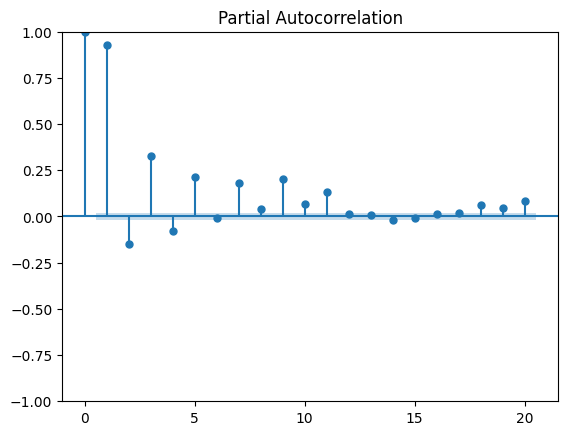

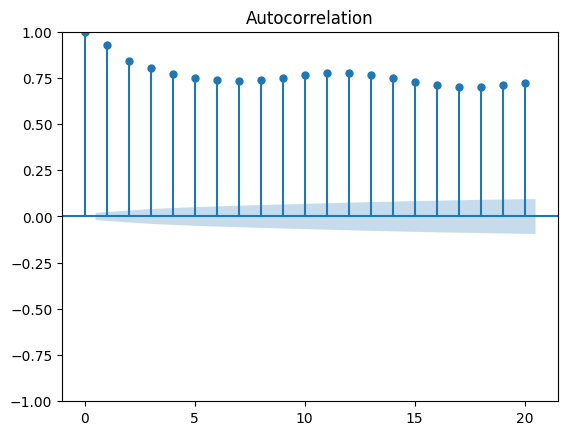

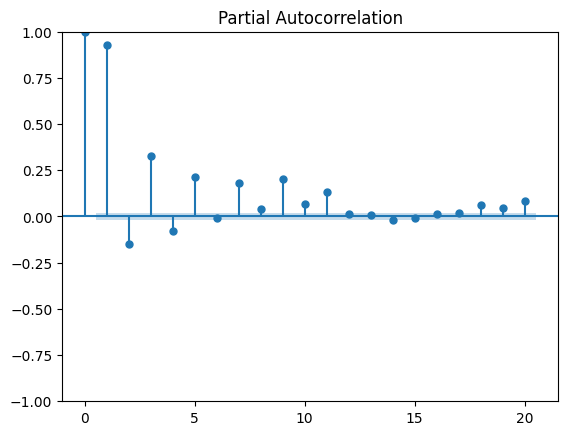

In [ ]:
# the price time series is stationary, so d=0

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming your stationary series is stored in 'stationary_series'
plot_acf(price_series, lags=20)
plot_pacf(price_series, lags=20)


It seems p=3. It is not so clear for q. We take q=3 also

Training and forecasting:

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Fit ARIMA model on the entire training set
order = (3, 0, 3)  # Replace p, d, q with your chosen ARIMA order
model = ARIMA(train_data, order=order)
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [ ]:
last_pred_length=48 #12, 24, 36, 48

# 2. Make predictions on the last data points of the test set
start_index = len(test_data) - last_pred_length
end_index = len(test_data) - 1
predictions = result.predict(start=start_index, end=end_index, typ='levels')

# 3. Evaluate the model's performance
actual_values = test_data.iloc[start_index:end_index + 1]
mae=mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (RMSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1.2222523667859233
Mean Squared Error (RMSE): 1.5867372014769876
Root Mean Squared Error (RMSE): 1.2596575731034954
